In [5]:
# Install kagglehub if you haven't
!pip install kagglehub

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, Reshape,GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Lambda
import matplotlib.pyplot as plt
import random
import string

# Configuration
IMAGE_SIZE = (128, 128, 3)  # Increased image size
MAX_TEXT_LENGTH = 100       # Reduced from 100 to better match small image size
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.0002
BIT_LENGTH = MAX_TEXT_LENGTH * 8  # 400 bits

In [7]:
# Text processing functions
def generate_random_text():
    """Generate random text for training"""
    length = random.randint(1, MAX_TEXT_LENGTH)
    chars = string.ascii_letters + string.digits + ' ,.!?'
    return ''.join(random.choice(chars) for _ in range(length))

def text_to_binary(text, max_length=MAX_TEXT_LENGTH):
    """Convert text to a padded binary string (length = max_length * 8)"""
    text = text[:max_length]  # Trim to max length
    binary_str = ''.join(format(ord(char), '08b') for char in text)
    # Pad with '0' to reach full bit length
    return binary_str.ljust(max_length * 8, '0')

def binary_to_text(binary_input):
    """Convert binary (string or array) back to text"""
    # Convert array to string if needed
    if isinstance(binary_input, (list, np.ndarray)):
        binary_str = ''.join(str(int(b)) for b in binary_input)
    elif isinstance(binary_input, str):
        binary_str = binary_input
    else:
        raise TypeError("Input must be a binary string, list, or NumPy array")

    # Convert 8-bit segments to characters
    text = ''
    for i in range(0, len(binary_str), 8):
        byte = binary_str[i:i+8]
        if byte == '00000000':  # Early stop on null character
            break
        text += chr(int(byte, 2))
    return text


In [8]:
import os
import kagglehub

# Download latest version of DIV2K dataset
path = kagglehub.dataset_download("soumikrakshit/div2k-high-resolution-images")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/div2k-high-resolution-images


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os

def load_images_with_augmentation(image_dir, image_size=IMAGE_SIZE, limit=None, augment=False):
    image_paths = sorted([
        os.path.join(image_dir, fname) for fname in os.listdir(image_dir)
        if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])
    if limit:
        image_paths = image_paths[:limit]

    images = []
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    ) if augment else None

    for path in image_paths:
        img = load_img(path, target_size=image_size)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
        if augment:
            img_aug = datagen.random_transform(img_array)
            images.append(img_aug)

    return np.array(images)


In [10]:
TRAIN_DIR = os.path.join(path, "DIV2K_train_HR", "DIV2K_train_HR")
VAL_DIR = os.path.join(path, "DIV2K_valid_HR", "DIV2K_valid_HR")

In [11]:
print("Loading training images...")
X_train = load_images_with_augmentation(TRAIN_DIR, limit=1000,augment=True)

print("Loading validation images...")
X_val = load_images_with_augmentation(VAL_DIR, limit=100,augment=False)


Loading training images...
Loading validation images...


In [12]:
#Generate random messages
texts_train = [generate_random_text() for _ in range(len(X_train))]
texts_val = [generate_random_text() for _ in range(len(X_val))]

# Convert to binary
y_train = np.array([[float(b) for b in text_to_binary(t)] for t in texts_train])
y_val = np.array([[float(b) for b in text_to_binary(t)] for t in texts_val])

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (1600, 128, 128, 3)
X_val shape: (100, 128, 128, 3)
y_train shape: (1600, 800)
y_val shape: (100, 800)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.layers import Dense, Reshape, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def build_encoder():
    image_input = Input(shape=(128, 128, 3), name='image_input')
    text_input = Input(shape=(800,), name='text_input')

    # Text Processing
    x_text = Dense(128*128, activation='relu')(text_input)
    x_text = Reshape((128, 128, 1))(x_text)
    x_text = Conv2D(32, (3,3), padding='same')(x_text)
    x_text = BatchNormalization()(x_text)
    x_text = Activation('relu')(x_text)

    # Image Processing
    x_img = Conv2D(32, (3,3), padding='same')(image_input)
    x_img = BatchNormalization()(x_img)
    x_img = Activation('relu')(x_img)

    # Combine branches
    x = Concatenate(axis=-1)([x_img, x_text])
    x = Conv2D(64, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Output
    output = Conv2D(3, (3,3), padding='same', activation='sigmoid')(x)
    output = Add()([output, image_input])

    return Model(inputs=[image_input, text_input], outputs=output, name='encoder')

def build_decoder():
    stego_input = Input(shape=(128, 128, 3), name='stego_input')

    # Feature extraction
    x = Conv2D(64, (3,3), padding='same')(stego_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Downsample blocks
    for _ in range(3):
        x = Conv2D(128, (3,3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # Final processing
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(800, activation='sigmoid', name='decoder_output')(x)

    return Model(inputs=stego_input, outputs=output, name='decoder')

# Build models
encoder = build_encoder()
decoder = build_decoder()

# Combined model
stego_image = encoder([encoder.input[0], encoder.input[1]])
decoded_text = decoder(stego_image)
combined_model = Model(
    inputs=encoder.input,
    outputs=[stego_image, decoded_text],  # List of outputs
    name='combined_model'
)

# Custom losses
def image_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred)) * 0.7

def text_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) * 0.3

# Compile with list outputs
combined_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=[image_loss, text_loss],
    metrics=[None, 'binary_accuracy']  # First output (image) has no metric
)

# Training callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_dense_1_binary_accuracy',  # Automatic output name
        factor=0.5,
        patience=3,
        mode='max'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_dense_1_binary_accuracy',
        patience=5,
        restore_best_weights=True,
        mode='max'
    )
]

# Train the model
history = combined_model.fit(
    [X_train, y_train],  # Inputs as list
    [X_train, y_train],  # Targets as list
    validation_split=0.1,
    batch_size=32,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - decoder_binary_accuracy: 0.6346 - decoder_loss: 0.1975 - encoder_loss: 0.1609 - loss: 0.3584 - val_decoder_binary_accuracy: 0.7742 - val_decoder_loss: 0.1826 - val_encoder_loss: 0.1330 - val_loss: 0.3156 - learning_rate: 1.0000e-04
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - decoder_binary_accuracy: 0.7853 - decoder_loss: 0.1402 - encoder_loss: 0.0503 - loss: 0.1905 - val_decoder_binary_accuracy: 0.7708 - val_decoder_loss: 0.1446 - val_encoder_loss: 0.0751 - val_loss: 0.2198 - learning_rate: 1.0000e-04
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - decoder_binary_accuracy: 0.7868 - decoder_loss: 0.1164 - encoder_loss: 0.0198 - loss: 0.1362 - val_decoder_binary_accuracy: 0.7685 - val_decoder_loss: 0.1846 - val_encoder_loss: 0.0390 - val_loss: 0.2235 - learning_rate: 1.0000e-04
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - decoder_binary_accuracy: 0.7921 - decoder_loss: 0.1107 - encoder_loss: 0.0111 - loss:

In [15]:
# Demonstration functions
def hide_text_in_image(image_array, text):
    """Hide text in an image and return the stego image"""
    binary_text = np.array([float(b) for b in text_to_binary(text)])

    # Expand dimensions for batch
    image_batch = np.expand_dims(image_array, axis=0)
    text_batch = np.expand_dims(binary_text, axis=0)

    # Generate stego image
    stego_image = encoder.predict([image_batch, text_batch], verbose=0)[0]
    return stego_image

def extract_text_from_image(stego_image):
    """Extract hidden text from a stego image"""
    image_batch = np.expand_dims(stego_image, axis=0)
    binary_output = decoder.predict(image_batch, verbose=0)[0]
    binary_str = ''.join(['1' if bit > 0.5 else '0' for bit in binary_output])
    return binary_to_text(binary_str)


In [16]:
# Test with sample images
sample_idx = random.randint(0, len(X_val) - 1)
sample_image = X_val[sample_idx]
sample_text = binary_to_text(y_val[sample_idx])

print("\n=== Demonstration ===")
print("Original Text:", sample_text)

# Hide the text
stego_img = hide_text_in_image(sample_image, sample_text)

# Extract the text
extracted_text = extract_text_from_image(stego_img)
print("Extracted Text:", extracted_text)


=== Demonstration ===
Original Text: ,jv vKjgP8?fQAvWmMMkGpcRSTY8b,LXY4lbAO5mMnLmDB8EG!
Extracted Text: ``f`wbbqskfwauarudaqfupppdqqfhwqqwwuswesdub`@@


In [17]:
# Calculate accuracy
original_binary = ''.join(['1' if b > 0.5 else '0' for b in y_val[sample_idx]])
extracted_binary = ''.join(['1' if b > 0.5 else '0' for b in decoder.predict(np.expand_dims(stego_img, axis=0), verbose=0)[0]])
bit_accuracy = sum(1 for a, b in zip(original_binary, extracted_binary) if a == b) / len(original_binary)
print(f"Bit Accuracy: {bit_accuracy:.2%}")

Bit Accuracy: 83.38%


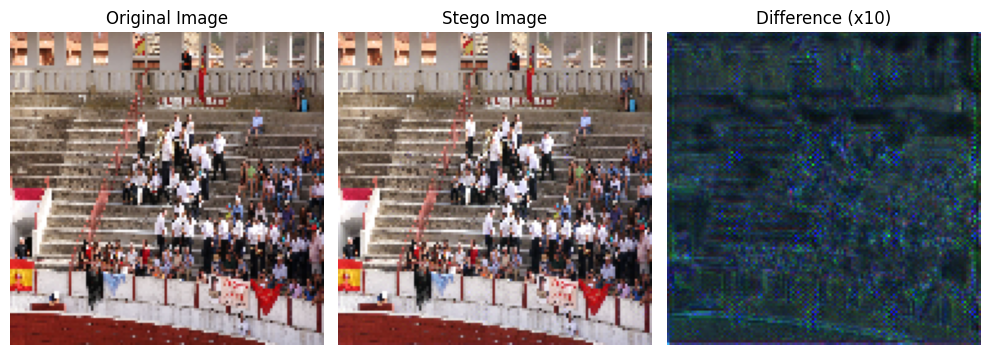

In [19]:
# Display results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Stego Image")
plt.imshow(stego_img)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Difference (x10)")
plt.imshow(np.abs(sample_image - stego_img) * 10)
plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def evaluate_on_validation_set(X_val, y_val):
    total_bits = 0
    correct_bits = 0
    total_ssim = 0.0
    num_images = len(X_val)

    for i in range(num_images):
        original_image = X_val[i]
        original_bits = y_val[i]  # Already binary (numpy array of 0/1)

        # Hide binary data in image
        stego_image = encoder.predict([np.expand_dims(original_image, axis=0),
                                       np.expand_dims(original_bits, axis=0)], verbose=0)[0]

        # Extract binary data from image
        predicted_bits = decoder.predict(np.expand_dims(stego_image, axis=0), verbose=0)[0]
        predicted_bits = (predicted_bits > 0.5).astype(np.float32)  # Threshold to binary

        # Bitwise accuracy
        min_len = min(len(original_bits), len(predicted_bits))
        correct = np.sum(original_bits[:min_len] == predicted_bits[:min_len])
        total_bits += len(original_bits)
        correct_bits += correct

        # SSIM computation
        if original_image.shape[-1] == 3:  # RGB
            ssim_score = np.mean([
                ssim(original_image[:, :, c], stego_image[:, :, c], data_range=1.0)
                for c in range(3)
            ])
        else:
            ssim_score = ssim(original_image.squeeze(), stego_image.squeeze(), data_range=1.0)

        total_ssim += ssim_score

    # Results
    avg_bitwise_accuracy = correct_bits / total_bits
    avg_ssim = total_ssim / num_images

    print(f"Average Bitwise Accuracy: {avg_bitwise_accuracy * 100:.2f}%")
    print(f"Average SSIM: {avg_ssim:.4f}")


In [22]:
evaluate_on_validation_set(X_val, y_val)

Average Bitwise Accuracy: 81.43%
Average SSIM: 0.9844


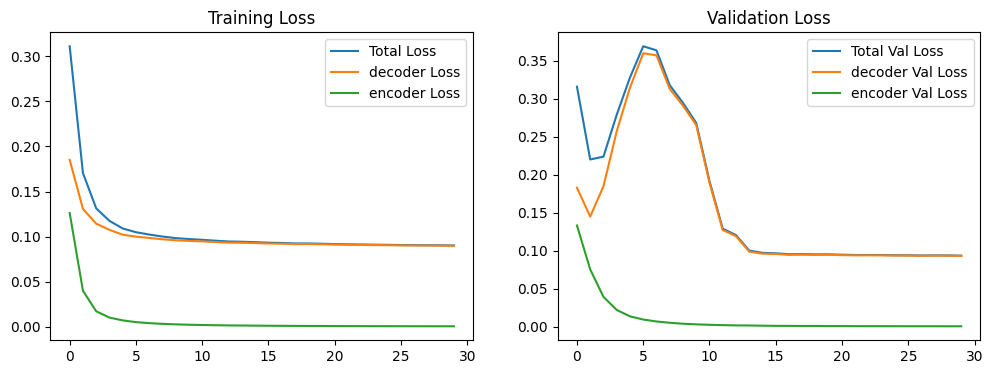

In [20]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['decoder_loss'], label='decoder Loss')
plt.plot(history.history['encoder_loss'], label='encoder Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Total Val Loss')
plt.plot(history.history['val_decoder_loss'], label='decoder Val Loss')
plt.plot(history.history['val_encoder_loss'], label='encoder Val Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()
